# Определение возраста покупателей

**Содержание:**   
1. [Исследовательский анализ данных](#section_1)  

2. [Обучение модели](#section_2)      
 2.1. [Загрузка обучающей и тестовой выборки](#section_2_1)  
 2.2. [Создание модели](#section_2_2)  
 2.3. [Обучение модели](#section_2_3)  
 2.4. [Результаты расчёта на GPU](#section_2_4)  
 
 
3. [Анализ обученной модели](#section_3)  

4. [Общий вывод](#section_4)

**Заказчик исследования:** сетевой супермаркет.

**Цель исследования:** создание модели прогнозирования, способной по фотографии определить возраст клиента.

**Требования к модели:**  метрика MAE на тестовой выборке не должна превышать 0.8.

**Описание данных**

Исходные данные содержатся в следующих файле "labels.csv":
 - "file_name" — имя файла,
 - "real_age" — реальный возраст. 

## Исследовательский анализ данных
<a id="section_1"></a>

Импортируем библиотеки:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загружаем данные:

In [2]:
path = '/datasets/faces/'
data = pd.read_csv(path + 'labels.csv')

Общая информация по датафрейму:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
print("Размер выборки:", data.shape)

Размер выборки: (7591, 2)


Визуализируем распределение количества изображений по возрастам:

In [5]:
def count_ages(data):
    df = data.groupby(['real_age'])['file_name'].count()
    fig = plt.figure(figsize=(15,12))
    df.plot.bar()
    plt.title('Распределение количества изображений по возрастам')
    plt.xlabel('Возраст')
    plt.ylabel('Количество наблюдений')
    plt.xticks(range(-1, data['real_age'].max(), 5))
    plt.show()

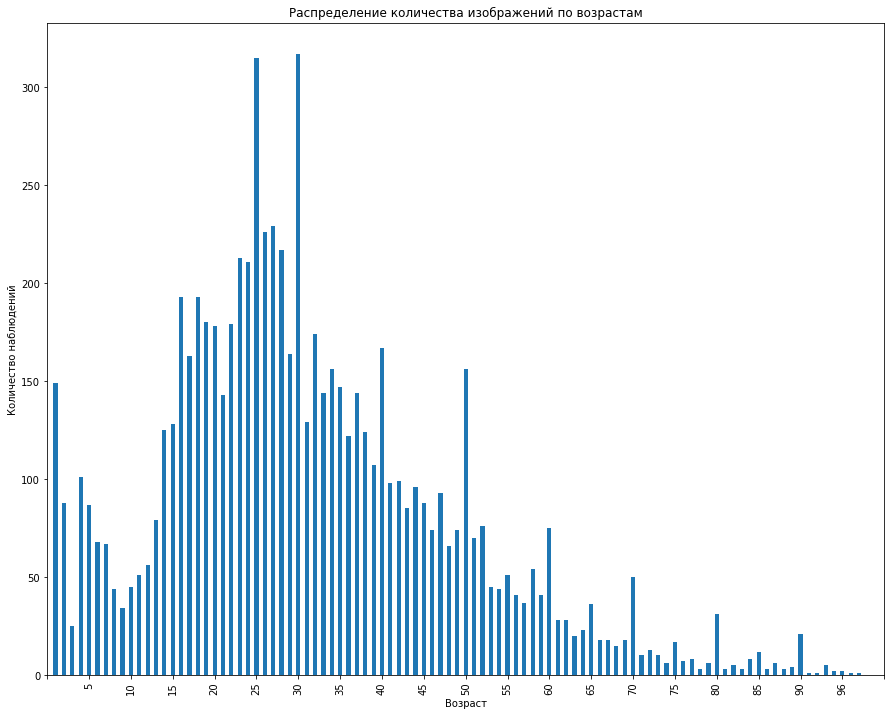

In [6]:
count_ages(data)

Распределение количества изображений по возрастам - левостороннее, с преобладанием частот малых значений.

Определяем распределение количества фотографий по возрастным группам:

In [7]:
def age_periods(data):
    step = 10
    for i in range(0, data['real_age'].max(), step):
        data.loc[(data['real_age'] > i) & (data['real_age'] <= i + step), 'age_period'] = str(i) + '-' + str(i + step)
    df = data.groupby(['age_period'])['real_age'].count()
    fig = plt.figure(figsize=(15,12))
    df.plot.bar()
    plt.title('Распределение количества изображений по возрастам')
    plt.xlabel('Возрастная группа')
    plt.ylabel('Количество наблюдений')
    plt.show()

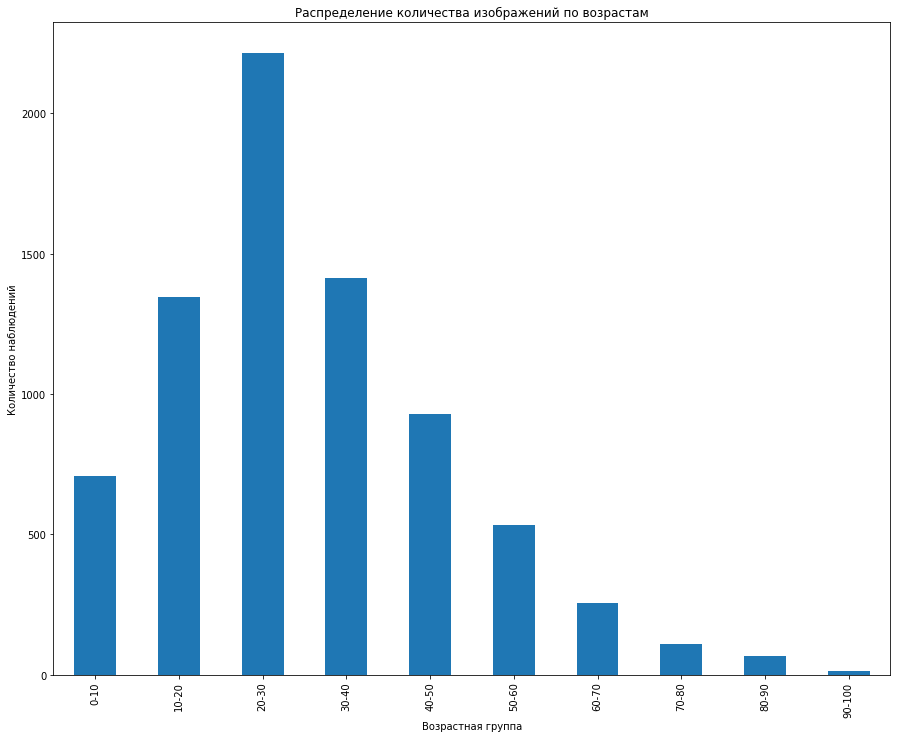

In [8]:
age_periods(data)

В выборке наиболее широко представлены изображения возрастной группы 20-30 лет.

Проверяем данные на наличие выбросов:

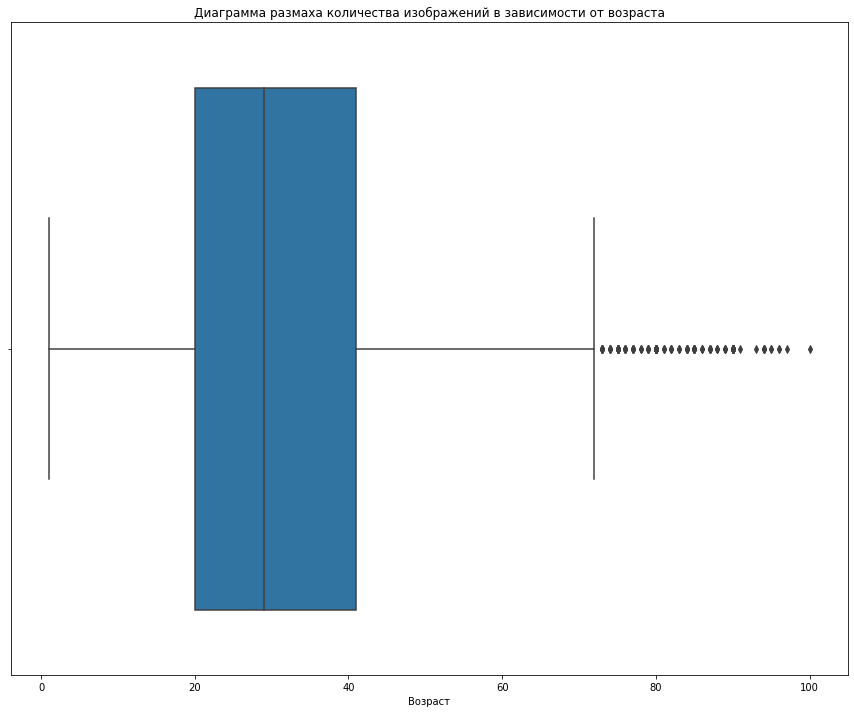

In [9]:
fig = plt.figure(figsize=(15,12))
sns.boxplot(x=data['real_age'])
plt.title('Диаграмма размаха количества изображений в зависимости от возраста')
plt.xlabel('Возраст')
plt.show()

В выборке присутствуют выбросы в большую сторону. Эти значения не являются аномальными, а обусловлены левосторонним расмпеделением: преобладают частоты малых значений.

На основании данных создаем тензор:

In [10]:
datagen = ImageDataGenerator(rescale=1/255)                                      
 
train_generator = datagen.flow_from_dataframe(dataframe=data,
                                              directory=path + 'final_files',
                                              x_col='file_name',
                                              y_col='real_age',
                                              target_size=(150, 150),
                                              batch_size=32,
                                              class_mode='raw',
                                              seed=12345
                                             )

Found 7591 validated image filenames.


Разделяем исходный тензор на тензоры признаков и целевого признака:

In [11]:
features, target = next(train_generator)

Печатаем 20 фотографий из выборки:

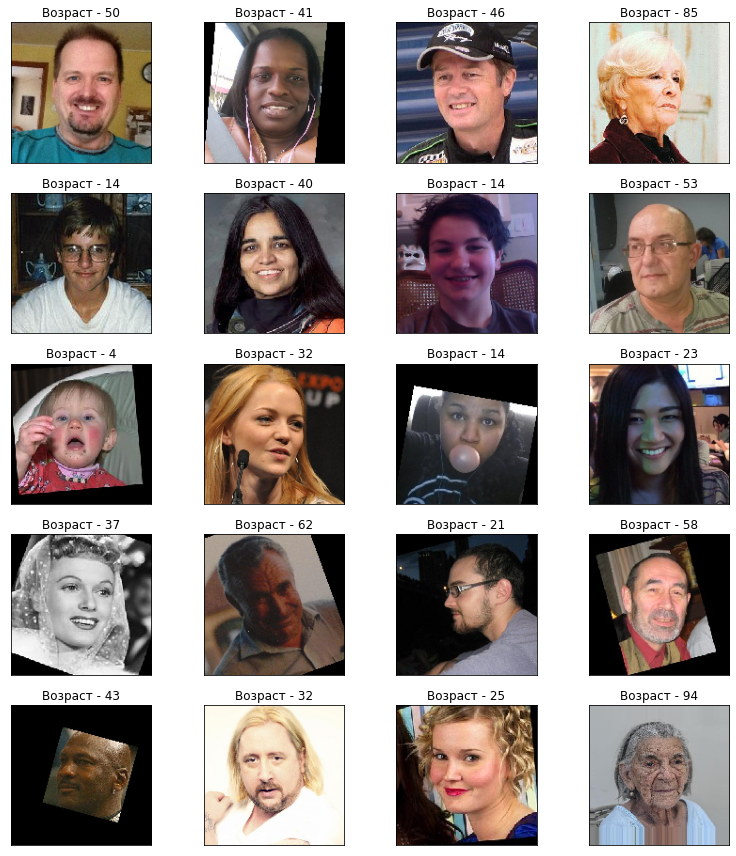

In [12]:
fig = plt.figure(figsize=(12,12))
for i in range(20):
    fig.add_subplot(5, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст - {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

Определяем структуру тензора признаков:

In [13]:
features.shape

(32, 150, 150, 3)

**Вывод:**  

1. В датафрейме 7591 наблюдений и 2 признака:  
 - file_name (имя файла);  
 - real_age (реальный возраст).  
2. Параметры загруженных изображений:
 - количество пикселей - 150x150;
 - количество цветовых каналов - 3.
3. Распределение количества изображений по возрастам - левостороннее, с преобладанием частот малых значений.
4. В выборке наиболее широко представлены изображения возрастной группы 20-30 лет.
5. В выборке присутствуют выбросы в большую сторону. Эти значения не являются аномальными, а обусловлены левосторонним расмпеделением: преобладают частоты малых значений.
6. Классы с меткой 65 и выше представлены недостаточным количеством наблюдений: от 1 до 50. Обучающую выборку можно увеличить посредством агументация, но, тем не менее, синтезированных данных может оказаться недостаточно для эффективного определения части классов. Имеет смысл объединить классы с метками 65 и выше в общую группу. Но возможность данного преобразования необходимо согласовать с заказчиком.
7. В выборке присутствуют изображения:
 - повернутые относительно вертикали.
 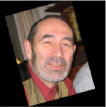
 - черно-белые.
 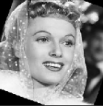
 - с лицами как в фас, так и в профиль.
 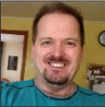
 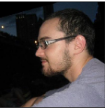
 - как фотографии высокого качества, так и низкого, сделанные, судя по всему, на пленочные фотоаппараты.
 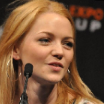
 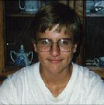
 - с посторонними предметами закрывающими часть лица.
 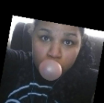
 - как с высокой, так и низкой яркостью.
 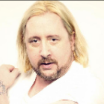
 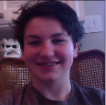

## Обучение модели
<a id="section_2"></a>

### Загрузка обучающей и тестовой выборки
<a id="section_2_1"></a>

Загружаем и преобразовываем в тензоры данные обучающей выборки:

In [14]:
def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255,
                                         horizontal_flip=True,
                                         width_shift_range=0.2, height_shift_range=0.2,
                                         validation_split=0.25
                                         )
    train_datagen_flow = train_datagen.flow_from_dataframe(
              dataframe = data,
              directory = path + 'final_files',
              x_col = 'file_name',
              y_col = 'real_age',
              class_mode = 'raw',
              target_size = (150,150),
              batch_size = 32,
              subset='training',
              seed=12345
              )
    return train_datagen_flow

In [15]:
train_datagen_flow = load_train(path)

Found 5694 validated image filenames.


Загружаем и преобразовываем в тензоры данные тестовой выборки:

In [16]:
def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255,
                                        validation_split=0.25
                                        )
    test_datagen_flow = test_datagen.flow_from_dataframe(
              dataframe = data,
              directory = path + 'final_files',
              x_col = 'file_name',
              y_col = 'real_age',
              class_mode = 'raw',
              target_size = (150,150),
              batch_size = 32,
              subset='validation',
              seed=12345
              )
    return test_datagen_flow

In [17]:
test_datagen_flow = load_test(path)

Found 1897 validated image filenames.


### Создание модели
<a id="section_2_2"></a>

Создаем модель из четырех слоев:
- ResNet50;
- GlobalAveragePooling2D;
- Dense;
- Dense.  

Функция потерь - MSE.  
Метрика - МАЕ.  

In [18]:
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
   
    model = Sequential()
    optimizer = Adam(lr=0.0001)
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model

In [ ]:
input_shape = (150, 150, 3)
model = create_model(input_shape)

2023-09-18 19:32:44.164371: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Обучение модели
<a id="section_2_3"></a>

Обучаем модель:

In [ ]:
def train_model(model, train_data, test_data, batch_size=32, epochs=6,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

In [ ]:
model = train_model(model, train_datagen_flow, test_datagen_flow)

### Результаты расчёта на GPU
<a id="section_2_4"></a>

Train for 178 steps, validate for 60 steps  
Epoch 1/6   
178/178 - 67s - loss: 259.6055 - mae: 11.5792 - val_loss: 770.4306 - val_mae: 22.8388
Epoch 2/6  
178/178 - 60s - loss: 100.5304 - mae: 7.5554 - val_loss: 737.1222 - val_mae: 22.2364
Epoch 3/6  
178/178 - 60s - loss: 79.8497 - mae: 6.8233 - val_loss: 338.8786 - val_mae: 13.5766
Epoch 4/6  
178/178 - 60s - loss: 65.6572 - mae: 6.2380 - val_loss: 182.5285 - val_mae: 10.5515
Epoch 5/6  
178/178 - 60s - loss: 55.0037 - mae: 5.7022 - val_loss: 199.5635 - val_mae: 10.5247
Epoch 6/6  
178/178 - 60s - loss: 46.1293 - mae: 5.2784 - val_loss: 81.9376 - val_mae: 6.8948  
WARNING:tensorflow:sample_weight modes were coerced from  
  ...  
    to  
  ['...']  
60/60 - 9s - loss: 81.9376 - mae: 6.8948  
Test MAE: 6.8948  

## Анализ обученной модели
<a id="section_3"></a>

1. Количество наблюдений:
 - в обучающей выборке - 5694;
 - в тестовой выборке - 1897.
2. Модель состоит из четырех слоев:
- ResNet50;
- GlobalAveragePooling2D;
- Dense;
- Dense.  

Функция потерь - MSE.  
Метрика - МАЕ.  

3. Условие по значению MAE (не более 8) для тестовой выборки достигнуто на 6 эпохе обучения При этом переобучение не наблюдается.  
Значение MAE на 6 эпохе - 6.8948.

## Общий вывод
<a id="section_4"></a>

**Исследовательский анализ данных**  

1. В датафрейме 7591 наблюдений и 2 признака:  
 - file_name (имя файла);  
 - real_age (реальный возраст).
2. Параметры загруженных изображений:
 - количество пикселей - 150x150;
 - количество цветовых каналов - 3.
3. Распределение количества изображений по возрастам - левостороннее, с преобладанием частот малых значений.
4. В выборке наиболее широко представлены изображения возрастной группы 20-30 лет.
5. В выборке присутствуют выбросы в большую сторону. Эти значения не являются аномальными, а обусловлены левосторонним расмпеделением: преобладают частоты малых значений.
6. Классы с меткой 65 и выше представлены недостаточным количеством наблюдений: от 1 до 50. Обучающую выборку можно увеличить посредствам агументация, но, тем не менее, синтезированных данных может оказаться недостаточно для эффективного определения части классов. Имеет смысл объединить классы с метками 65 и выше в общую группу. Но возможность данного преобразования необходимо согласовать с заказчиком.
7. В выборке присутствуют изображения:
 - повернутые относительно вертикали.
 - черно-белые.
 - с лицами как в фас, так и в профиль.
 - как фотографии высокого качества, так и низкого, сделанные, судя по всему, на пленочные фотоаппараты.
 - с посторонними предметами закрывающими часть лица.
 - как с высокой, так и низкой яркостью.
 
 
**Обучение модели**  

1. Выборка разделена на обучающую и тестовую в отношении 3:1.
2. Проведена агументация изображений обучающей выборки.  
3. Обучена модель из четырех слоев:
- ResNet50;
- GlobalAveragePooling2D;
- Dense;
- Dense.  

    Функция потерь - MSE.  
    Метрика - МАЕ.

4. Условие по значению MAE (не более 8) для тестовой выборки достигнуто на 6 эпохе обучения При этом переобучение не наблюдается.  
Значение MAE на 6 эпохе - 6.8948.